In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  9 02:08:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import numpy as np
import pandas as pd
import time

#from wordcloud import WordCloud
#from matplotlib import pyplot as plt

#import gensim
#import string
#from gensim import corpora
#from gensim.test.utils import common_texts
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()

## 확인 필요. 문제 없으면 지울 수 있음. ##
# Check versions to ensure that there are no compatability issues:
python_version = !python --version
print("Python Version: ", python_version)
print("Current Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Python Version:  ['Python 3.7.12']
Current Directory:  /content
Numpy version:  1.19.5
Pandas version:  1.1.5


## Test Data List 만들기
Full_Text로 section 2('_2')의 CEO's review/letter 데이터를 사용했다. 여기서는 DataFrame 으로 Full_Text 파일 리스트를 만들어주었다. 문서의 수는 372개. 

In [ ]:
test_list = os.listdir("/content/drive/MyDrive/Aiffel_Hackathon/Data/Validation/validation_sections_2")
len(test_list)
test_df = pd.DataFrame(test_list, columns=['Original_Filename'])
test_df['Original_Filename'] = test_df['Original_Filename'].str.replace('.txt', '')
test_df[['Document', 'Middle', 'Section']] = test_df['Original_Filename'].str.split('_').tolist()

test_df.head()


372

,Original_Filename,Document,Middle,Section
0,30777_904926_2,30777,904926,2
1,30778_904963_2,30778,904963,2
2,30779_904986_2,30779,904986,2
3,30781_905026_2,30781,905026,2
4,30782_905054_2,30782,905054,2


In [ ]:
# section 2 확인 
test_df.loc[test_df['Section'] != "2"]

,Original_Filename,Document,Middle,Section


## Full_Text Data 읽어와서 DataFrame 에 붙이기
Txt 에 있는 Full_Text 를 하나씩 가져와서 DataFrame에 추가시켜 주었다. 중복데이터 제거후 370개의 데이터 존재. 

In [ ]:
%cd /content/drive/MyDrive/Aiffel_Hackathon/Data/Validation/validation_sections_2

/content/drive/MyDrive/Aiffel_Hackathon/Data/Validation/validation_sections_2


In [ ]:
test_list = [x + str(".txt") for x in test_df['Original_Filename']]
len(test_list)

372

In [ ]:
file_path = '/content/drive/MyDrive/Aiffel_Hackathon/Data/Validation/validation_sections_2/'

sentence_list = [] 
for i in test_list: 
  with open(file_path + i, "r", encoding='utf-8') as f: 
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line 
    sentence_list.append(temp_str)

In [ ]:
len(sentence_list)
sentence_list[10]

372

' Strategic Report 06 Spirax-Sarco Engineering plc Annual Report 2017 Group Chief Executive’s Statement  Implementing our strategy for growth Key points in this section:  ›  Successfully implementing our  strategy for organic growth  › Acquisition of two outstanding  businesses: Gestra  and Chromalox  › Delivering long-term  sustainable value  for stakeholders less likely to be cut in times of recession.  This\xa0“self-generated” element of our  business, combined with the high proportion  of sales that derive from end users’  maintenance and operating budgets, and  the wide diversity of the markets we serve,  both geographically and by industry sector,  makes our business highly resilient, although  not immune, to the vagaries of the markets. Strategy implementation Four years ago we undertook an extensive  strategic review and developed our strategy  for growth, the aim of which is to deliver  self-generated growth that outperforms our  markets. We identified six Group strategic  the

In [ ]:
test_df['Full_Text'] = sentence_list
test_df.head()

,Original_Filename,Document,Middle,Section,Full_Text
0,30777_904926_2,30777,904926,2,25695 19 March 2018 3:29 PM Proof 7 02 ...
1,30778_904963_2,30778,904963,2,10 Staffline Group plc Annual Report 2017 Chi...
2,30779_904986_2,30779,904986,2,Our strategy is delivering results National...
3,30781_905026_2,30781,905026,2,Results Corero revenue for the year ended 31 ...
4,30782_905054_2,30782,905054,2,The Group has delivered continued progress i...


In [ ]:
# 중복 확인 
print('원본파일 개수: ', len(test_df))
test_df.drop_duplicates(subset=['Full_Text'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['Original_Filename'], keep='first', inplace=True)
print('중복 제거후 원본파일 개수: ', len(test_df))

원본파일 개수:  372
중복 제거후 원본파일 개수:  370


In [ ]:
# setting index
test_df.set_index('Original_Filename', inplace=True)

In [ ]:
test_df1 = test_df[['Full_Text']].copy()

In [ ]:
print(len(test_df1))
test_df1.head()

370


,Full_Text
Original_Filename,
30777_904926_2,25695 19 March 2018 3:29 PM Proof 7 02 ...
30778_904963_2,10 Staffline Group plc Annual Report 2017 Chi...
30779_904986_2,Our strategy is delivering results National...
30781_905026_2,Results Corero revenue for the year ended 31 ...
30782_905054_2,The Group has delivered continued progress i...


## Full_Text Length Review
Full_Text의 길이분포를 보고 단어의 숫자가 500개 이하 또는 4000개 이상인 문서는 삭제해줬다. 문서의 총수는 330개.

In [ ]:
test_df2 = test_df1.reset_index()
test_df2.head()

,Original_Filename,Full_Text
0,30777_904926_2,25695 19 March 2018 3:29 PM Proof 7 02 ...
1,30778_904963_2,10 Staffline Group plc Annual Report 2017 Chi...
2,30779_904986_2,Our strategy is delivering results National...
3,30781_905026_2,Results Corero revenue for the year ended 31 ...
4,30782_905054_2,The Group has delivered continued progress i...


In [ ]:
for i, doc in enumerate(test_df2['Full_Text']):
  test_df2.loc[i, 'FT_Len'] = len(doc.split())

In [ ]:
len(test_df2)

370

count      370.000000
mean      2236.759459
std       1471.780158
min         43.000000
25%       1338.250000
50%       1883.000000
75%       2780.750000
max      13355.000000
Name: FT_Len, dtype: float64

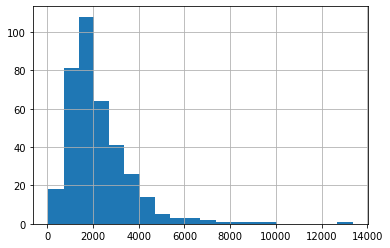

In [ ]:
test_df2['FT_Len'].describe()
test_df2['FT_Len'].hist(bins=20)

In [ ]:
# check outliers (short or no data)
test_df2.loc[test_df2['FT_Len'] < 50]

,Original_Filename,Full_Text,FT_Len
295,32437_956774_2,10 CEO’S REPORT Subhransu (“Brian”) Mukherje...,43.0


In [ ]:
# check outliers (long text)
over4000 = test_df2.loc[test_df2['FT_Len'] > 4000].copy()
print(len(over4000))
print("ratio: ", len(over4000)/len(test_df2['FT_Len'])*100)

33
ratio:  8.91891891891892


In [ ]:
over500 = 500 < test_df2['FT_Len']
less4000 = 4000 > test_df2['FT_Len']
test_df3 = test_df2.loc[over500 & less4000].copy()
len(test_df3)

330

## Full_Text 전처리

In [ ]:
def preprocessing(sentence): 
  sentence = sentence.lower()
  sentence = re.sub("[$]", "dollar ", sentence)
  sentence = re.sub("[£]", "pound ", sentence)
  sentence = re.sub("[%]", " percent", sentence)
  sentence = re.sub(r"[^a-zA-Z0-9?!.,’-]", ' ', sentence)
  sentence = re.sub(r"([?!])", r" \1 ", sentence)
  sentence = re.sub(r'([a-z])(?=[.,])', r'\1 ', sentence)
  sentence = re.sub(r"\s+", " ", sentence)
  return sentence

In [ ]:
# full text testing
pro_sample1 = preprocessing(test_df3['Full_Text'][0])
pro_sample1

' 25695 19 march 2018 3 29 pm proof 7 02 s . c . harris group chief executive chief executive’s review 2017 has once again demonstrated the quality of bodycote’s business . the group’s revenue growth , combined with continued discipline on costs , helped lift headline operating profit by 24 percent . return on sales increased to 18.0 percent from 16.6 percent . s . c . harris group chief executive overview bodycote reported revenue growth of 14.9 percent to pound 690.2m 2016 pound 600.6m , with revenue benefiting from foreign exchange translation gain . at constant currency , revenues grew 9.6 percent , including a contribution of 2.9 percent from acquisitions completed in 2016. the following review reflects constant currency growth rates unless stated otherwise . general industrial markets returned to growth after a multi- year negative trend . moreover , this growth was broad-based , with improvements in general industrial demand occurring in all of our served geographies . group rev

In [ ]:
unclean_full_text = list(test_df3['Full_Text'])
clean_full_text =[]
for item in unclean_full_text: 
  sentences = preprocessing(item)
  clean_full_text.append(sentences)

In [ ]:
# Replace the columns with the clean data
test_df3['Full_Text'] = clean_full_text
# sample 
print(test_df3['Full_Text'][0])

 25695 19 march 2018 3 29 pm proof 7 02 s . c . harris group chief executive chief executive’s review 2017 has once again demonstrated the quality of bodycote’s business . the group’s revenue growth , combined with continued discipline on costs , helped lift headline operating profit by 24 percent . return on sales increased to 18.0 percent from 16.6 percent . s . c . harris group chief executive overview bodycote reported revenue growth of 14.9 percent to pound 690.2m 2016 pound 600.6m , with revenue benefiting from foreign exchange translation gain . at constant currency , revenues grew 9.6 percent , including a contribution of 2.9 percent from acquisitions completed in 2016. the following review reflects constant currency growth rates unless stated otherwise . general industrial markets returned to growth after a multi- year negative trend . moreover , this growth was broad-based , with improvements in general industrial demand occurring in all of our served geographies . group reve

In [ ]:
test_df3.head()

,Original_Filename,Full_Text,FT_Len
0,30777_904926_2,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,1517.0
1,30778_904963_2,10 staffline group plc annual report 2017 chi...,3684.0
3,30781_905026_2,results corero revenue for the year ended 31 ...,1639.0
5,30783_905079_2,strategic report chief executive’s statement ...,1071.0
6,30785_905133_2,summary our dedication to providing our clien...,1071.0


In [ ]:
len(test_df3)

330

## Label 만들기 

### 필요한 모듈 설치하기 

In [ ]:
! pip install sumy
! pip install nltk

     |████████████████████████████████| 87 kB 4.7 MB/s 
     |████████████████████████████████| 10.1 MB 68.9 MB/s 
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21711 sha256=f2ee49f2d8349e05efb5ceaf1950696342cf903007edf6b29372a6f8029ff52f
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=82e4873ef9eb77fdd57152da3882978dfbcc5c9d8168ee97efa21436a701668c
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built breadability pycountry


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Edmundson Summarizer (파이썬 내장함수 사용)
4가지 method가 있는데 여기서는 cue_method만 사용했다. 

* cue_method:These are the key words that are manually selected and are highly correlated with the importance of sentences. 파이썬 내장 라이브러리에서는 bonus, stigma 단어로 rating을 정한다. 
Cue weight = Σ (Cue weight of each word in sentence)  
  * Bonus words   
These are the words pointing towards the important sentences. These may include superlatives ,adverbs etc.   

  * Stigma words   
These are the words that have negative addect on the sentence importance. It includes anaphoric expressions, belittling expressions, etc.(We may expect the machine to treat them important but they are not really.)    

In [ ]:
print ("--EdmundsonSummarizer--")    

e_summarizer = EdmundsonSummarizer(cue_weight=1.0, key_weight=0,
            title_weight=0, location_weight=0) 

words1 = ("acquisition", "risk", "purchase", "reorganisation", "hedge", "investment", "asset", "sell", "related", "affiliate", "cash", "debt", "increase", "goodwill", "buy", "merge", "decrease", "loan", "restructure")
e_summarizer.bonus_words = words1
   
words2 = ("chief executive", "annual report", "letter")
e_summarizer.stigma_words = words2
    
# 'revenue', 'operating' 는 중요한 단어이므로 stop words에서 제외시켰다. 
words3 = ('the','.', 'and', ',', 'of', 'to', 'in', 'a', 'our', 'we', 'for', 'with', 'is', 'year', 'on', 'percent', 'as', 'pound', 'this', 'have', 'are', 'by', 'has', 'business'
'that', 'from', 'new', 'at', 'will', 'group', 'market', 'growth', 'which', 'was', 'an', 'be', 'million', 'been', 'report', 'its','sales', 'us', 'it', 
'customers', 'also', 'over', 'during', 'services', 'more', 'chief',  'these' , 'uk', 'products', 'development', 'all', 'annual', 'further', 
'through', 'well', 'markets', 'management', 'continue', 'strong', 'performance', 'review', 'continued', 'financial', 'their', 'were', 'product', 'plc', 'i', 
'now','strategy', 'increased', 'service', 'customer', 'into')
 
e_summarizer.null_words = words3 # 80 stopwords (평균적으로 1 문서에 3번 이상 등장하는 단어들)


--EdmundsonSummarizer--


In [ ]:
sen_count = 12

In [ ]:
test_df4 = test_df3.reset_index(drop=True)
test_df4.head()

,Original_Filename,Full_Text,FT_Len
0,30777_904926_2,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,1517.0
1,30778_904963_2,10 staffline group plc annual report 2017 chi...,3684.0
2,30781_905026_2,results corero revenue for the year ended 31 ...,1639.0
3,30783_905079_2,strategic report chief executive’s statement ...,1071.0
4,30785_905133_2,summary our dedication to providing our clien...,1071.0


In [ ]:
for i, doc in enumerate(test_df4['Full_Text']): 
  p_text = PlaintextParser.from_string(doc, Tokenizer("english")) # parsing
  
  new_doc = ""
  for sentence in e_summarizer(p_text.document, sen_count): 
    new_doc += sentence._text # type is str, thus, concatenating with +

  test_df4.loc[i, 'Summary'] = new_doc

In [ ]:
test_df4.head()

,Original_Filename,Full_Text,FT_Len,Summary
0,30777_904926_2,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,1517.0,25695 19 march 2018 3 29 pm proof 7 02 s .c .h...
1,30778_904963_2,10 staffline group plc annual report 2017 chi...,3684.0,underlying profit before tax excludes amortisa...
2,30781_905026_2,results corero revenue for the year ended 31 ...,1639.0,results corero revenue for the year ended 31 d...
3,30783_905079_2,strategic report chief executive’s statement ...,1071.0,strategic report chief executive’s statement 1...
4,30785_905133_2,summary our dedication to providing our clien...,1071.0,summary our dedication to providing our client...


### Summary Text 길이 분석 및 내용 샘플 테스트 

In [ ]:
for i, doc in enumerate(test_df4['Summary']): 
  test_df4.loc[i, 'Summary_Len']= len(doc.split())


count     330.000000
mean      441.378788
std       142.821648
min       199.000000
25%       353.000000
50%       414.500000
75%       482.750000
max      1668.000000
Name: Summary_Len, dtype: float64

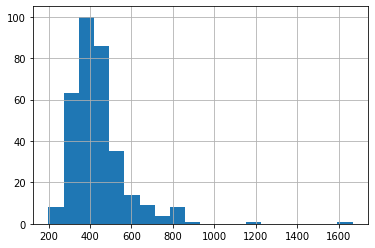

In [ ]:
test_df4['Summary_Len'].describe()
test_df4['Summary_Len'].hist(bins=20)

In [ ]:
# 파일이름 32248_950166_2, 32272_951157_2 확인결과 원본데이터의 텍스트가 퀄리티가 낮아서 사용할수 없으므로 삭제. 
over_800 = test_df4.loc[test_df4['Summary_Len'] > 800 ].copy()
over_800

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
6,30790_905290_2,2017 has been a year of significant change fo...,1622.0,2017 has been a year of significant change for...,1668.0
17,30822_906350_2,chief executive’s review intu focuses solely ...,2223.0,chief executive’s review intu focuses solely o...,805.0
34,30895_908713_2,chief executive’s strategic review making a d...,2374.0,chief executive’s strategic review making a di...,807.0
61,31023_912625_2,10 john laing annual report and accounts 2017...,3581.0,this was achieved despite the impact of lower ...,813.0
172,31831_936034_2,strategic report volution group plc annual re...,2213.0,"the acquisition of breathing buildings , a nat...",809.0
230,32168_947298_2,strategic report governance financial stateme...,3862.0,during the period fas also signed agreements w...,810.0
245,32248_950166_2,profit before tax pound 119.7m 2016 pound 43....,2805.0,profit before tax pound 119.7m 2016 pound 43.7...,1195.0
246,32272_951157_2,9 strategic report 1 25 governance 26 72 cons...,921.0,9 strategic report 1 25 governance 26 72 conso...,849.0
257,32380_955173_2,spread bet the group’s spread betting product...,2388.0,spread betting provides similar economic benef...,829.0
309,32966_971103_2,10 chariot oil gas limited annual report and ...,2770.0,10 chariot oil gas limited annual report and a...,917.0


In [ ]:
del_index = [245, 246]
test_df5 = test_df4.drop(index=del_index) 
len(test_df5)

328

In [ ]:
over_500 = test_df5.loc[test_df5['Summary_Len'] > 500 ].copy()
over_500.reset_index(drop=True, inplace=True)
over_500

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
0,30778_904963_2,10 staffline group plc annual report 2017 chi...,3684.0,underlying profit before tax excludes amortisa...,689.0
1,30781_905026_2,results corero revenue for the year ended 31 ...,1639.0,results corero revenue for the year ended 31 d...,531.0
2,30790_905290_2,2017 has been a year of significant change fo...,1622.0,2017 has been a year of significant change for...,1668.0
3,30795_905414_2,chief executive’s review profit growth in asi...,3375.0,savills studley’s revenue up 6 percent but pro...,639.0
4,30796_905440_2,strategic report 06 spirax-sarco engineering ...,1603.0,strategic report 06 spirax-sarco engineering p...,543.0
...,...,...,...,...,...
62,32825_968328_2,our performance in 2017 is our strongest on r...,1738.0,glencore’s balance sheet has never been strong...,595.0
63,32874_969646_2,"2017 was my first full year as ceo , and it h...",1485.0,"2017 was my first full year as ceo , and it ha...",556.0
64,32926_970385_2,4 kape technologies plc annual report and acc...,1843.0,we have built on our existing pc repair reimag...,681.0
65,32966_971103_2,10 chariot oil gas limited annual report and ...,2770.0,10 chariot oil gas limited annual report and a...,917.0


count      67.000000
mean     2243.791045
std       940.569839
min       532.000000
25%      1489.500000
50%      2223.000000
75%      2955.500000
max      3963.000000
Name: FT_Len, dtype: float64

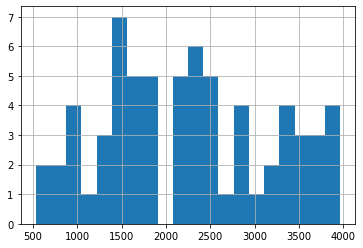

In [ ]:
over_500['FT_Len'].describe()
over_500['FT_Len'].hist(bins=20)

### Summa로 레이블 만들기
위에서 만든 레이블 중에서 길이가 너무 긴 레이블을 TexRank를 통해서 키워드 요약을 해준다. 

In [ ]:
!pip install summa

     |████████████████████████████████| 54 kB 3.1 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54410 sha256=96cb091e4e333907f0e97ae0173f4a3819da1d8e2e9a2a4b93d1b51c6b0ebd83
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
from summa.summarizer import summarize

In [ ]:
for i, doc in enumerate(over_500['Full_Text']): 
  new_doc = summarize(doc, words=400)
  over_500.loc[i, 'TR_Summary'] = new_doc

In [ ]:
for i, doc in enumerate(over_500['TR_Summary']): 
  over_500.loc[i, 'TR_Summary_Len'] = len(doc.split())


count     67.000000
mean     401.477612
std       21.650361
min      357.000000
25%      385.500000
50%      400.000000
75%      415.500000
max      463.000000
Name: TR_Summary_Len, dtype: float64

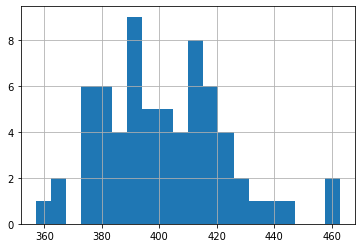

In [ ]:
over_500['TR_Summary_Len'].describe()
over_500['TR_Summary_Len'].hist(bins=20)

In [ ]:
print(over_500['TR_Summary'][5])

we concentrate exclusively on contracted wholesale power generation meaning focused activities disciplined and opportunistic growth strategy with a strong track record of delivering above market returns culture of operational excellence and safety drives top decile performance and competitive advantages focus on long-term contracted or regulated wholesale power generation producing low risk and efficient capital structure large global footprint diversified across geographies and technologies operate safely and efficiently and minimize environmental impacts .
we have a rigorous proven way of adding value to our assets health and safety comes first in everything we do creating a continuous improvement culture industry leading operational performance across all assets and divisions leveraging existing operational infrastructure for future growth competitive cost base structure with relentless focus on continued monitoring of fixed costs experienced and international senior management team

In [ ]:
over_500.drop(['Summary', 'Summary_Len'], axis=1, inplace=True)
over_500.rename(columns={'TR_Summary' : 'Summary', 'TR_Summary_Len': 'Summary_Len'}, inplace=True)
over_500.head()

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
0,30778_904963_2,10 staffline group plc annual report 2017 chi...,3684.0,andy hogarth chief executive officer kpis 2017...,422.0
1,30781_905026_2,results corero revenue for the year ended 31 ...,1639.0,businesses and government departments can prot...,381.0
2,30790_905290_2,2017 has been a year of significant change fo...,1622.0,read about our people pages 16 and 17 read abo...,444.0
3,30795_905414_2,chief executive’s review profit growth in asi...,3375.0,our performance by service line is set out bel...,357.0
4,30796_905440_2,strategic report 06 spirax-sarco engineering ...,1603.0,strategic report 06 spirax-sarco engineering p...,423.0


### Summa 로 만든 label을 test_df에 replace 하기 

In [ ]:
test_df6 = test_df5.loc[test_df5['Summary_Len'] <= 500].copy()
len(test_df6)

261

In [ ]:
len(over_500) + len(test_df6)

328

In [ ]:
test_df7 = pd.concat([test_df6, over_500], ignore_index=True)
len(test_df7)

328

In [ ]:
test_df7.head()

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
0,30777_904926_2,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,1517.0,25695 19 march 2018 3 29 pm proof 7 02 s .c .h...,334.0
1,30783_905079_2,strategic report chief executive’s statement ...,1071.0,strategic report chief executive’s statement 1...,407.0
2,30785_905133_2,summary our dedication to providing our clien...,1071.0,summary our dedication to providing our client...,318.0
3,30785_905134_2,"q a with ceo , david miles 92 percent of tena...",838.0,"q a with ceo , david miles 92 percent of tenan...",301.0
4,30813_906032_2,strategic report domino’s pizza group plc ann...,3428.0,"in the spring , we launched our walk in wins’ ...",446.0


count    328.000000
mean     391.079268
std       57.962604
min      199.000000
25%      352.750000
50%      397.500000
75%      428.000000
max      500.000000
Name: Summary_Len, dtype: float64

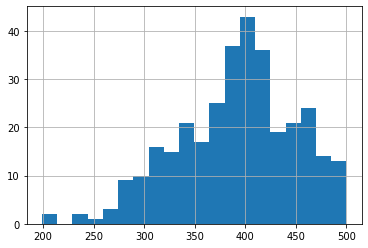

In [ ]:
test_df7['Summary_Len'].describe()
test_df7['Summary_Len'].hist(bins=20)

In [ ]:
test_df7.to_csv('/content/drive/MyDrive/Aiffel_Hackathon/Data/test_data_newlabel.csv')